In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output


pd.options.display.float_format = '{:20,.15f}'.format
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

current_month = '04'
next_month = '05'

start_time=f'2023-{current_month}-01 00:00:00'
stop_time=f'2023-{next_month}-01 00:00:00'

#start_time=f'2023-01-01 00:00:00'
#stop_time=f'2024-01-01 00:00:00'

tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)

In [2]:
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

69152 394


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000,2023-04-01 01:01:07.500000,33.100000000000001,10.800000000000001,15.000000000000000
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000,2023-04-01 03:40:13.900000,99.900000000000006,7.800000000000000,52.000000000000000
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000,2023-04-01 18:48:53.900000,89.900000000000006,7.200000000000000,57.000000000000000
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000,2023-04-01 03:05:38.800000,72.799999999999997,7.700000000000000,49.000000000000000
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000,2023-04-01 03:40:39.000000,32.899999999999999,10.100000000000000,15.000000000000000
...,...,...,...,...,...,...,...,...,...
389,1831,ETD93C,2023-04-30,2023.05.01-051342.db,2023-04-30 07:54:18.700000,2023-04-30 08:01:50.900000,134.099999999999994,9.199999999999999,26.000000000000000
390,1832,SAS936,2023-04-30,2023.05.01-051342.db,2023-04-30 10:36:26.000000,2023-04-30 10:56:51.900000,11.900000000000000,10.199999999999999,14.000000000000000
391,1833,SKIER71,2023-04-30,2023.05.01-051342.db,2023-04-30 12:55:21.500000,2023-04-30 15:07:20.000000,0.600000000000000,0.000000000000000,47.000000000000000
392,1834,SERGB,2023-04-30,2023.05.01-051342.db,2023-04-30 17:35:48.300000,2023-04-30 17:51:42.900000,66.099999999999994,10.500000000000000,2.000000000000000


In [3]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


In [ ]:
# get header information for flight durations
dates_to_exclude_from_analysis_due_to_missing_detector_data = []

temp_df = pd.DataFrame()
length = len(flights_distinct)
for i in range(length):
    clear_output(wait=True)
    f = tracker.get_flight_by_index(i, filetype = 'headers.root')
    if len(f.header_df) > 0:
        temp_df = pd.concat([temp_df, f.header_df], ignore_index=True, sort=False)
    else: 
        print(f'No detector data for {f.date}')
        dates_to_exclude_from_analysis_due_to_missing_detector_data.append(f.date)
    
    print(f'end: {i + 1}/{length}')
    #print(f.header_df)

# filter header information for days where detector was on
flights_distinct = flights_distinct[~flights_distinct['date'].isin(dates_to_exclude_from_analysis_due_to_missing_detector_data)]#.reset_index()
flights = flights[~flights['date'].isin(dates_to_exclude_from_analysis_due_to_missing_detector_data)]#.reset_index()

print('ready to join tables')


INFO:runtable_database:database connection to RNOG_live established


KeyboardInterrupt: 

In [6]:
#save the flights_distinct table with header information joined
con = sqlite3.connect('./header_files_for_time_range/header_2023')

# Write the DataFrame to the SQLite database
temp_df.to_sql(f'all_triggers_2023_{current_month}', con, if_exists = 'replace')

# Close the database connection
con.close()

In [4]:
#save the flights_distinct table with header information joined
con = sqlite3.connect('./header_files_for_time_range/header_2023')

# Write the DataFrame to the SQLite database
tables = pd.read_sql_query(f'Select name from sqlite_master where type = "table"', con)

# Close the database connection
con.close()
tables

,name
0,all_triggers_2023_03
1,all_triggers_2023_04
2,all_triggers_2023_06
3,all_triggers_2023_07
4,all_triggers_2023_08
5,all_triggers_2023_09
6,all_triggers_2023_10
7,all_triggers_2023_11
8,all_triggers_2023_05


In [5]:
temp_df = pd.DataFrame()
con = sqlite3.connect('./header_files_for_time_range/header_2023')
for table in tables.name:
    temp = pd.read_sql_query(f'Select * From {table}', con)
    if(len(temp_df == 0)):
        temp_df = temp
    else:
        temp_df = pd.concat([temp_df, temp], ignore_index=True, sort=False)
con.close()
temp_df

,index,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers
0,0,11.00,"2,084.00","7,422.00","1,682,928,352.21",1.00,0.00,0.00
1,1,11.00,"2,084.00","7,423.00","1,682,928,352.28",0.00,0.00,1.00
2,2,11.00,"2,084.00","7,424.00","1,682,928,352.55",1.00,0.00,0.00
3,3,11.00,"2,084.00","7,425.00","1,682,928,353.99",1.00,0.00,0.00
4,4,11.00,"2,084.00","7,426.00","1,682,928,354.94",1.00,0.00,0.00
...,...,...,...,...,...,...,...,...
9112751,9112751,24.00,"1,397.00",831.00,"1,685,526,800.99",0.00,1.00,0.00
9112752,9112752,24.00,"1,397.00",832.00,"1,685,526,801.76",0.00,1.00,0.00
9112753,9112753,24.00,"1,397.00",833.00,"1,685,526,802.99",0.00,1.00,0.00
9112754,9112754,24.00,"1,397.00",834.00,"1,685,526,803.65",0.00,1.00,0.00


In [4]:
con = sqlite3.connect('./header_files_for_time_range/header_2023')

temp_df = pd.read_sql_query(f'Select * from all_triggers_2023_04 where lt_triggers = 1', con)

con.close()
print(len(temp_df))

1523577


In [5]:
flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['ID'] = flights_distinct.index

temp_df['trigger_time_millis'] = (temp_df['trigger_time'] * (10 ** 3)).astype(np.int64)

flights_distinct


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_millis,maxtime_millis,ID
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000+00:00,2023-04-01 01:01:07.500000+00:00,33.10,10.80,15.00,2023-04-01_DLH9922,1680309752100,1680310867500,0
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000+00:00,2023-04-01 03:40:13.900000+00:00,99.90,7.80,52.00,2023-04-01_N/A,1680310777100,1680320413900,1
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000+00:00,2023-04-01 18:48:53.900000+00:00,89.90,7.20,57.00,2023-04-01_N/A,1680326488400,1680374933900,2
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000+00:00,2023-04-01 03:05:38.800000+00:00,72.80,7.70,49.00,2023-04-01_CSN312,1680317369100,1680318338800,3
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000+00:00,2023-04-01 03:40:39+00:00,32.90,10.10,15.00,2023-04-01_DLH491,1680319248200,1680320439000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1831,ETD93C,2023-04-30,2023.05.01-051342.db,2023-04-30 07:54:18.700000+00:00,2023-04-30 08:01:50.900000+00:00,134.10,9.20,26.00,2023-04-30_ETD93C,1682841258700,1682841710900,389
390,1832,SAS936,2023-04-30,2023.05.01-051342.db,2023-04-30 10:36:26+00:00,2023-04-30 10:56:51.900000+00:00,11.90,10.20,14.00,2023-04-30_SAS936,1682850986000,1682852211900,390
391,1833,SKIER71,2023-04-30,2023.05.01-051342.db,2023-04-30 12:55:21.500000+00:00,2023-04-30 15:07:20+00:00,0.60,0.00,47.00,2023-04-30_SKIER71,1682859321500,1682867240000,391
392,1834,SERGB,2023-04-30,2023.05.01-051342.db,2023-04-30 17:35:48.300000+00:00,2023-04-30 17:51:42.900000+00:00,66.10,10.50,2.00,2023-04-30_SERGB,1682876148300,1682877102900,392


In [8]:
temp_df.drop(['trigger_time'], inplace = True, axis = 1)

In [34]:
# join header information on flights_distinct
query = '''
SELECT 
    --date || '_' || flightnumber as fk_date_flightnumber
    flightnumber
    ,fk_date_flightnumber
    ,station_number
    ,count(trigger_time_millis) as triggers_per_second
    ,trigger_time_millis
    ,trigger_time_sec
    --,mintime
    --,mintime_millis
    --,maxtime
    --,maxtime_millis
    --,date
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                trigger_time_millis
                ,force_triggers
                ,station_number
                ,round(trigger_time_millis / 1000, 0) as trigger_time_sec
            FROM temp_df
)t0

ON trigger_time_millis > flights_distinct.mintime_millis
AND trigger_time_millis < flights_distinct.maxtime_millis
WHERE trigger_time_sec is not null
and min_r < 50
AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,flightnumber,fk_date_flightnumber,station_number,triggers_per_second,trigger_time_millis,trigger_time_sec
0,CPA095,2023-04-01_CPA095,21,6,1680338260318,"1,680,338,260.000000000000000"
1,CPA095,2023-04-01_CPA095,21,3,1680338263552,"1,680,338,263.000000000000000"
2,CPA095,2023-04-01_CPA095,21,3,1680338264079,"1,680,338,264.000000000000000"
3,CPA095,2023-04-01_CPA095,21,3,1680338265736,"1,680,338,265.000000000000000"
4,CPA095,2023-04-01_CPA095,21,3,1680338275883,"1,680,338,275.000000000000000"
...,...,...,...,...,...,...
247328,SKIER71,2023-04-30_SKIER71,24,2,1682867225497,"1,682,867,225.000000000000000"
247329,SKIER71,2023-04-30_SKIER71,24,2,1682867229398,"1,682,867,229.000000000000000"
247330,SKIER71,2023-04-30_SKIER71,24,2,1682867230143,"1,682,867,230.000000000000000"
247331,SKIER71,2023-04-30_SKIER71,24,2,1682867236549,"1,682,867,236.000000000000000"


In [31]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [35]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_millis / 10**3

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    temp_table['d'] = part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
result_df


2023-04-30_SAS935   ,  393 : 394
flightnumber: 2023-04-30_SAS935  


,flightnumber,fk_date_flightnumber,station_number,triggers_per_second,trigger_time_millis,trigger_time_sec,d
0,DLH9922,2023-04-01_DLH9922,21,1,1680309760296,"1,680,309,760.000000000000000",147.687059521675110
1,DLH9922,2023-04-01_DLH9922,21,1,1680309766442,"1,680,309,766.000000000000000",146.170664072036743
2,DLH9922,2023-04-01_DLH9922,21,1,1680309774485,"1,680,309,774.000000000000000",144.071033716201782
3,DLH9922,2023-04-01_DLH9922,21,2,1680309776140,"1,680,309,776.000000000000000",143.659394443035126
4,DLH9922,2023-04-01_DLH9922,21,1,1680309788217,"1,680,309,788.000000000000000",140.729143142700195
...,...,...,...,...,...,...,...
257918,SAS936,2023-04-30_SAS936,24,2,1682852198542,"1,682,852,198.000000000000000",146.351632833480835
257919,SAS936,2023-04-30_SAS936,24,4,1682852200548,"1,682,852,200.000000000000000",147.587684154510498
257920,SAS936,2023-04-30_SAS936,24,2,1682852202734,"1,682,852,202.000000000000000",148.570957899093628
257921,SAS936,2023-04-30_SAS936,24,2,1682852210323,"1,682,852,210.000000000000000",149.321249022014626


In [33]:

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]

KeyError: 'flightnumber'

In [26]:
test = sqldf('Select avg(triggers_per_second) as avg_triggers_per_sec, d from result_df group by d')

In [25]:
sqldf('Select count(d), d from result_df group by d')

,count(d),d
0,2833,0.000000000000000
1,9901,1.000000000000000
2,11352,2.000000000000000
3,7938,3.000000000000000
4,1547,4.000000000000000
...,...,...
145,1974,145.000000000000000
146,1384,146.000000000000000
147,867,147.000000000000000
148,568,148.000000000000000


In [16]:
test

,avg_triggers_per_sec,d
0,2.38,0.53
1,2.00,0.53
2,2.00,0.54
3,2.00,0.54
4,2.00,0.54
...,...,...
241690,6.00,149.89
241691,3.00,149.89
241692,3.00,149.90
241693,2.00,149.92


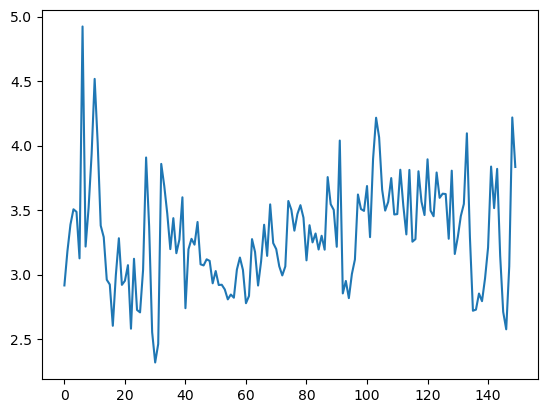

In [27]:
plt.plot(test.d, test.avg_triggers_per_sec)

Text(0, 0.5, '# triggers [Hz]')

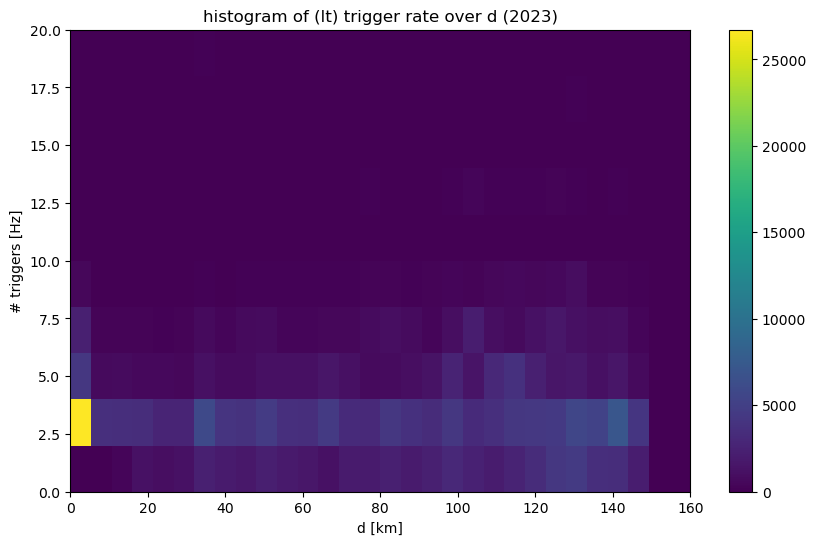

In [28]:
from matplotlib.colors import LogNorm
#result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
max_index = result_df['triggers_per_second'].idxmax()

plt.figure(figsize=(10, 6))
# Get the flightnumber at this index
#max_flightnumber = result_df.at[max_index, 'flightnumber']
#print(max_flightnumber)
#h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0, 15]], bins = [100, 10])
h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0,20]], bins = [30, 10])#, range = [[0, 160], [0, 15]], bins = [100, 15])#, norm = LogNorm())
plt.colorbar()
#plt.semilogy()
plt.title('histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_2023.pdf')

Text(0, 0.5, '# counts')

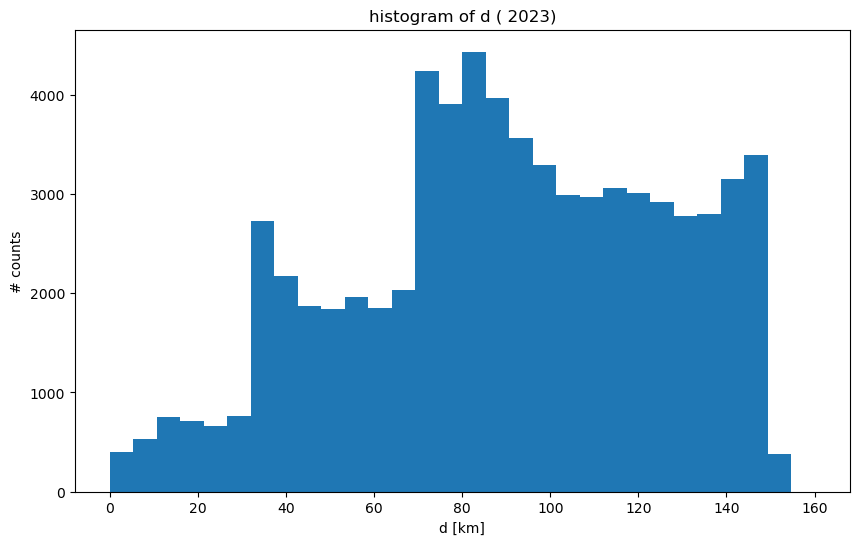

In [29]:
plt.figure(figsize=(10, 6))
a = plt.hist(np.sqrt(flights.r2), bins = xedges)

plt.title('histogram of d ( 2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# counts')
#plt.savefig('./saved_figures/hist_d_2023.pdf')

/tmp/ipykernel_6829/2947665761.py:2: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, h.T/a[0])


Text(0, 0.5, '# triggers [Hz]')

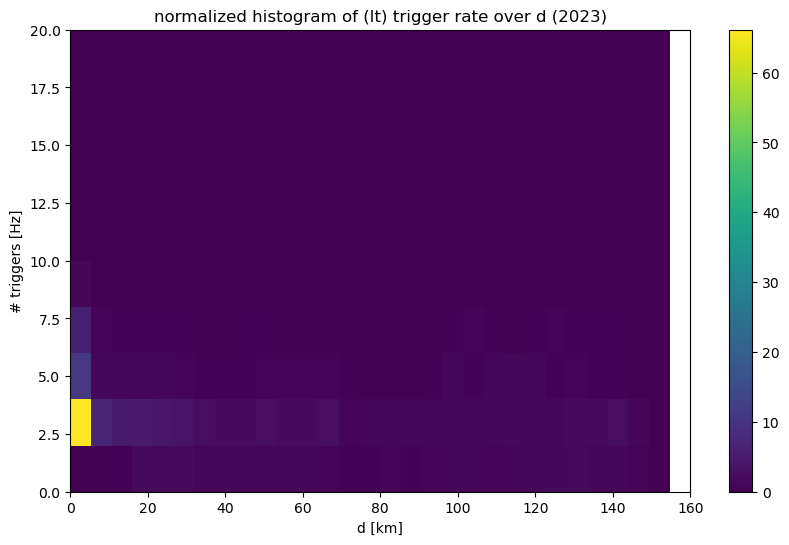

In [30]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, h.T/a[0])
plt.colorbar()
plt.title('normalized histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_NORMALIZED_2023_0.pdf')

In [7]:
pd.options.display.float_format = '{:20,.2f}'.format

In [7]:
temp_df.trigger_time_millis

0          1682928357386
1          1682928369010
2          1682928369503
3          1682928371716
4          1682928374912
               ...      
4856104    1685526800990
4856105    1685526801763
4856106    1685526802987
4856107    1685526803648
4856108    1685526803869
Name: trigger_time_millis, Length: 4856109, dtype: int64

In [9]:
flights_distinct.mintime_stamp

0      1682971758100
1      1682929487600
2      1682938024100
3      1682938787800
4      1682941053800
           ...      
603    1685511484700
604    1685526407300
605    1685512489600
606    1685515941400
607    1685526804200
Name: mintime_stamp, Length: 608, dtype: int64